In [1]:
# import required packages
from fastai.tabular import *

In [2]:
# path to project directory
path = Path('/home/jupyter/fpl-prediction')

In [3]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train.csv', index_col=0, dtype={'season':str})

In [4]:
train_df.tail()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba
82802,Heurelho da Silva_Gomes,26,1,0,Watford,Brighton and Hove Albion,0.476769,0.467411,False,0,...,1,1,0.0,-60,112,172,0,2020-02-08T17:30:00Z,1920,1.0
82803,Joseph_Anang,26,1,0,West Ham United,Manchester City,0.758450,2.653289,False,0,...,0,2,0.0,132,529,397,0,2020-02-19T19:30:00Z,1920,1.0
82804,Erik_Pieters,26,2,0,Burnley,Southampton,0.402621,0.452499,False,0,...,2,1,0.0,-8007,617,8624,0,2020-02-15T12:30:00Z,1920,1.0
82805,Japhet_Tanganga,26,2,0,Tottenham Hotspur,Aston Villa,1.845990,0.537651,False,0,...,3,2,0.0,68650,74632,5982,0,2020-02-16T14:00:00Z,1920,1.0
82806,Ravel_Morrison,26,3,0,Sheffield United,Bournemouth,0.293816,0.704973,True,0,...,1,2,0.0,-322,11,333,0,2020-02-09T14:00:00Z,1920,0.0


In [5]:
# exclude zero minute rows
#train_df = train_df[train_df['minutes'] != 0].reset_index()

In [6]:
train_df.shape

(82807, 35)

In [7]:
# find the latest gameweek
last_gw = train_df['gw'][train_df['season'] == '1920'].max()

if np.isnan(last_gw): 
    next_gw = 1 
else: 
    next_gw = last_gw + 1
    
next_gw

27

In [8]:
# find validation cut point - index for 18-19 season second half (gw 19)
#valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
# or take validation as same as current prediction set
valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == next_gw)].index.min()
valid_end = train_df[(train_df['season'] == '1920') & (train_df['gw'] == 1)].index.min()
#valid_end = train_df.index.max()

In [9]:
# check data types
train_df.dtypes

player                                  object
gw                                       int64
position                                 int64
minutes                                  int64
team                                    object
opponent_team                           object
relative_market_value_team             float64
relative_market_value_opponent_team    float64
was_home                                  bool
total_points                             int64
assists                                  int64
bonus                                    int64
bps                                      int64
clean_sheets                             int64
creativity                             float64
goals_conceded                           int64
goals_scored                             int64
ict_index                              float64
influence                              float64
own_goals                                int64
penalties_missed                         int64
penalties_sav

In [10]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes', 'relative_market_value_team', 'relative_market_value_opponent_team']#, 'ppg_total', 'points_last_5']

In [11]:
# set dependent variable
dep_var = 'total_points'

In [12]:
# set validation dataset based on indexes calculated earlier
valid_idx = range(valid_start, valid_end)

In [13]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]

In [14]:
# create databunch
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

In [15]:
# set range of predictions - minimum to current max
max_y = np.max(train_df['total_points'])
min_y = np.min(train_df['total_points'])
y_range = torch.tensor([-1, max_y], device=defaults.device)

In [16]:
# instatiate tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [17]:
# take a look at the nueral net architecture
# note that categorical variables all have embeddings (used default embedding sizes)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1262, 87)
    (1): Embedding(39, 12)
    (2): Embedding(5, 4)
    (3): Embedding(30, 11)
    (4): Embedding(30, 11)
    (5): Embedding(3, 3)
    (6): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=135, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [ ]:
learn.lr_find()

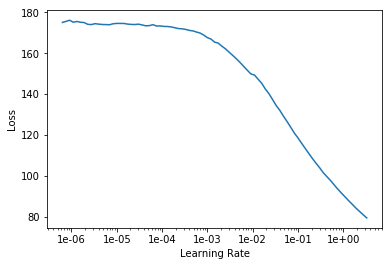

In [166]:
learn.recorder.plot()

In [ ]:
# no market value, latest half season validation
# learn.fit_one_cycle(3, 1.1e-2, wd=0.2)

In [43]:
# market value, latest half season validation
# learn.fit_one_cycle(3, 1.5e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,10.148968,8.108212,2.815272,00:02
1,7.744442,7.921211,2.780680,00:02
2,6.750823,7.586754,2.719187,00:02


In [22]:
# no market value, new season validation
# learn.fit_one_cycle(4, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,8.286838,8.456475,2.861300,00:02
1,7.342739,7.591846,2.721933,00:02
2,7.386149,7.513053,2.702131,00:02
3,6.645412,7.562900,2.718028,00:02


In [18]:
# CURRENT APPROACH
# market value, new season validation
learn.fit_one_cycle(2, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.608098,3.797059,1.875449,00:17
1,3.512409,3.436914,1.792386,00:07


In [19]:
# second training run with lower LR
learn.fit_one_cycle(1, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.358256,3.438513,1.793355,00:07


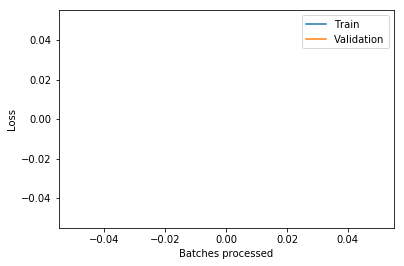

In [25]:
learn.recorder.plot_losses()

In [20]:
# add predictions to the validations set
df_valid = train_df.loc[valid_idx]
df_valid['predicted_points'] = learn.get_preds()[0].data.numpy().T[0]

In [21]:
# look at one team/gameweek
df_valid[(df_valid['team'] == 'Cardiff City') & (df_valid['opponent_team'] == 'Chelsea')].head(10)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,predicted_points
63316,Alex_Smithies,32,1,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-19,38,57,0,2019-03-31T13:05:00Z,1819,NaN,-0.070804
63354,Anthony_Pilkington,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-19,6,25,0,2019-03-31T13:05:00Z,1819,NaN,-0.066522
63363,Aron_Gunnarsson,32,3,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,...,1,0.0,-1228,1105,2333,1,2019-03-31T13:05:00Z,1819,NaN,2.745375
63367,Ashley Darel Jazz_Richards,32,2,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-169,705,874,0,2019-03-31T13:05:00Z,1819,NaN,-0.039156
63408,Bobby_Reid,32,4,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-3081,3293,6374,0,2019-03-31T13:05:00Z,1819,NaN,0.008574
63414,Brian_Murphy,32,1,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-73,175,248,0,2019-03-31T13:05:00Z,1819,NaN,-0.046156
63418,Bruno_Ecuele Manga,32,2,90,Cardiff City,Chelsea,0.18389,2.540586,True,1,...,1,0.0,1000,2500,1500,0,2019-03-31T13:05:00Z,1819,NaN,1.646971
63425,Callum_Paterson,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-4989,198,5187,0,2019-03-31T13:05:00Z,1819,NaN,0.010508
63493,Danny_Ward_2,32,3,0,Cardiff City,Chelsea,0.18389,2.540586,True,0,...,1,0.0,-71,243,314,0,2019-03-31T13:05:00Z,1819,NaN,0.026616
63503,David Junior_Hoilett,32,3,90,Cardiff City,Chelsea,0.18389,2.540586,True,2,...,1,5.0,448,840,392,0,2019-03-31T13:05:00Z,1819,NaN,2.903224


In [22]:
# look at top predictions
df_valid.sort_values('predicted_points', ascending=False).head(20)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,predicted_points
66509,Mohamed_Salah,36,3,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,19,...,5,97.0,71136,83818,12682,0,2019-04-26T19:00:00Z,1819,NaN,11.261394
63182,Mohamed_Salah,31,3,90,Liverpool,Fulham,2.177887,0.405284,False,2,...,1,66.0,-37072,46372,83444,0,2019-03-17T14:15:00Z,1819,NaN,10.881367
65818,Mohamed_Salah,35,3,90,Liverpool,Cardiff City,2.177887,0.183890,False,6,...,0,55.0,-23964,33993,57957,0,2019-04-21T15:00:00Z,1819,NaN,9.990323
61572,Mohamed_Salah,28,3,90,Liverpool,Watford,2.177887,0.412301,True,3,...,5,67.0,-43453,16296,59749,0,2019-02-27T20:00:00Z,1819,NaN,9.852457
66596,Sadio_Mané,36,3,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,13,...,5,49.0,168266,187216,18950,0,2019-04-26T19:00:00Z,1819,NaN,9.471134
62786,Mohamed_Salah,30,3,90,Liverpool,Burnley,2.177887,0.449442,True,5,...,4,60.0,-75411,16257,91668,0,2019-03-10T12:00:00Z,1819,NaN,9.226522
63223,Sadio_Mané,31,3,90,Liverpool,Fulham,2.177887,0.405284,False,13,...,1,42.0,241454,249016,7562,0,2019-03-17T14:15:00Z,1819,NaN,9.134986
66122,Andrew_Robertson,36,2,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,14,...,5,6.0,15389,32054,16665,0,2019-04-26T19:00:00Z,1819,NaN,8.721775
64436,Mohamed_Salah,33,3,90,Liverpool,Southampton,2.177887,0.654624,False,6,...,1,51.0,52512,87671,35159,1,2019-04-05T19:00:00Z,1819,NaN,8.718575
63995,Riyad_Mahrez,32,3,90,Manchester City,Cardiff City,2.540586,0.183890,True,3,...,2,44.0,2420,4392,1972,0,2019-04-03T18:45:00Z,1819,NaN,8.713696


In [23]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])

4.728021621704102

In [24]:
prev_pt_mean = np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['total_points'])
prev_pt_mean

4.523

In [25]:
## now we have decided training approach, need to apply to remainder of season
# read in remaining_season.csv
remaining_season_df = pd.read_csv(path/'data/remaining_season.csv', index_col=0)

In [26]:
remaining_season_df.head(50)
#remaining_season_df[remaining_season_df.player == 'Trent_Alexander-Arnold']

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes
0,27,Arsenal,Everton,Shkodran_Mustafi,2,5.1,1.00,True,1.437198,0.978426,1920,67.500
1,27,Arsenal,Everton,Héctor_Bellerín,2,5.4,1.00,True,1.437198,0.978426,1920,90.000
2,27,Arsenal,Everton,Sead_Kolasinac,2,5.2,1.00,True,1.437198,0.978426,1920,45.000
3,27,Arsenal,Everton,Ainsley_Maitland-Niles,2,4.6,1.00,True,1.437198,0.978426,1920,36.000
4,27,Arsenal,Everton,Sokratis_Papastathopoulos,2,4.9,0.75,True,1.437198,0.978426,1920,16.875
5,27,Arsenal,Everton,Nacho_Monreal,2,5.0,0.00,True,1.437198,0.978426,1920,0.000
6,27,Arsenal,Everton,Laurent_Koscielny,2,5.0,0.00,True,1.437198,0.978426,1920,0.000
7,27,Arsenal,Everton,Konstantinos_Mavropanos,2,4.4,0.00,True,1.437198,0.978426,1920,0.000
8,27,Arsenal,Everton,Carl_Jenkinson,2,4.5,0.00,True,1.437198,0.978426,1920,0.000
9,27,Arsenal,Everton,Rob_Holding,2,4.5,1.00,True,1.437198,0.978426,1920,1.800


In [27]:
# create new databunch, with remaining season as test set
# and using all available data i.e. no validation
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_none()
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(remaining_season_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [28]:
# instatiate new tabular learner
# learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
#                         y_range=y_range, metrics=rmse)

In [29]:
# train as before
# learn.fit_one_cycle(2, 1e-2, wd=0.2)

In [30]:
# learn.fit_one_cycle(1, 1e-3, wd=0.2)

In [31]:
# get predictions
# test_preds=learn.get_preds(DatasetType.Test)
# remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]

In [32]:
# check mean of top predictions to see if it's reasonably close to previous season's actuals
# re-run if not - not ideal but at the moment the training often over-predicts top players
# pred_pt_mean = np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])
# pred_pt_mean

In [37]:
while True:
    # instatiate new tabular learner
    learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                            y_range=y_range, metrics=rmse)
    
    # train as before
    learn.fit_one_cycle(2, 1e-2, wd=0.2)
    learn.fit_one_cycle(1, 1e-3, wd=0.2)

    # get predictions
    test_preds=learn.get_preds(DatasetType.Test)
    remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]
    
    # check mean of top predictions to see if it's reasonably close to previous season's actuals
    # re-run if not - not ideal but at the moment the training often over-predicts top players
    pred_pt_mean = np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])
    
    if abs((prev_pt_mean - pred_pt_mean) / prev_pt_mean) < 0.07:
        print("Mean of top 1000 predictions: {:.4}".format(pred_pt_mean))
        break
    else:
        print("{:.4}...retraining...".format(pred_pt_mean))

Mean of top 1000 predictions: 4.338


In [38]:
remaining_season_df.shape

(7488, 13)

In [39]:
# quick look
remaining_season_df.sort_values(by='predicted_points', ascending=False).head(20)

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes,predicted_points
782,29,Liverpool,Bournemouth,Mohamed_Salah,3,12.8,1.0,True,2.447608,0.704973,1920,88.50,9.855914
158,27,Liverpool,West Ham United,Mohamed_Salah,3,12.8,1.0,True,2.447608,0.758450,1920,88.50,9.667243
2602,35,Liverpool,Burnley,Mohamed_Salah,3,12.8,1.0,True,2.447608,0.402621,1920,88.50,9.614272
1341,31,Liverpool,Crystal Palace,Mohamed_Salah,3,12.8,1.0,True,2.447608,0.473067,1920,88.50,9.219181
1965,33,Liverpool,Aston Villa,Mohamed_Salah,3,12.8,1.0,True,2.447608,0.537651,1920,88.50,9.032408
4315,28,Liverpool,Watford,Mohamed_Salah,3,12.8,1.0,False,2.447608,0.476769,1920,88.50,8.742501
6035,34,Liverpool,Brighton and Hove Albion,Mohamed_Salah,3,12.8,1.0,False,2.447608,0.467411,1920,88.50,8.552797
7405,38,Liverpool,Newcastle United,Mohamed_Salah,3,12.8,1.0,False,2.447608,0.640348,1920,88.50,8.400620
3226,37,Liverpool,Chelsea,Mohamed_Salah,3,12.8,1.0,True,2.447608,1.744281,1920,88.50,8.290903
4789,30,Liverpool,Everton,Mohamed_Salah,3,12.8,1.0,False,2.447608,0.978426,1920,88.50,8.005720


In [40]:
# rename previous week's predictions file
# generate previous week's filename
last_gw = next_gw - 1
filename = 'predictions_gw' + str(last_gw) + '.csv'
! mv predictions.csv $filename

In [41]:
# write to predictions.csv
## RENAME PREVIOUS WEEK FIRST
predictions = remaining_season_df[['gw', 'player', 'team', 'position', 'price', 'play_proba', 'predicted_points']]
predictions.to_csv('predictions.csv')